# UNSW-NB15: Machine Learning Models

In [ ]:
file_path = "./final_ipynb"

## Importing libraries

In [ ]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading files

In [ ]:
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_dict = pickle.load(open(file_path+'/saved_dict.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

In [ ]:
# Making the train data sparse matrix
x_train_csr = csr_matrix(x_train.values)

col = x_train.columns

# Creating sparse dataframe with x_train sparse matrix
x_train = pd.DataFrame.sparse.from_spmatrix(x_train_csr, columns=col)

In [ ]:
# Saving it to disk to use later
pickle.dump((x_train, y_train), open(file_path+'/train_sparse.pkl', 'wb'))

# Loading sparse data
x_train, y_train = pickle.load(open(file_path+'/train_sparse.pkl', 'rb'))

In [ ]:
x_train.sparse.to_dense().head()

,sttl,dttl,swin,trans_depth,res_bdy_len,stime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_dst_ltm,ct_src_ltm,ct_dst_sport_ltm,dur_log1p,sbytes_log1p,dbytes_log1p,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,...,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_None,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_ECO,state_ECR,state_FIN,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,2.561444,-0.717760,-1.196045,-0.225343,-0.089113,-1.172764,-0.057567,-0.055099,-0.136439,-0.128893,-0.123848,-0.04053,2.541751,-0.198264,-0.132020,-0.111699,-0.665012,-0.666629,-0.719387,-0.419757,-0.251062,-1.052109,-1.703404,-1.383776,-1.879995,-0.704801,-1.190007,-1.189697,-1.137341,-1.850553,0.204270,-0.899657,-1.229918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.037542,-0.717760,-1.196045,-0.225343,-0.089113,0.868469,-0.069616,-0.055099,-0.136439,-0.128893,-0.123848,-0.04053,-0.382468,-0.198264,-0.132020,-0.111699,0.996846,1.172325,1.109976,0.714379,-0.447582,-0.813189,-1.703404,1.614925,-1.879995,-1.080734,-1.190007,-1.189697,0.565988,-1.850553,-0.995343,-0.899657,-1.062092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.157401,-0.069485,-0.054857,-0.121383,-0.107394,-0.118110,-0.04053,-0.382468,-0.198264,-0.132020,-0.111699,0.812195,-0.421435,-0.353515,-0.419757,-0.417344,0.563887,0.911063,0.153252,0.988351,0.843701,0.741629,0.888925,-0.582651,0.881301,-0.995343,0.170283,0.894089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.136357,-0.063807,-0.044512,-0.120830,-0.107159,-0.117296,-0.04053,-0.382468,-0.198264,7.574602,5.349858,-0.757337,-0.176241,-0.597430,-0.419757,0.768030,0.651189,0.437147,-1.071111,-0.033644,1.032630,0.895318,0.770420,-0.793357,-0.012242,1.251851,0.515730,0.318009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.144197,-0.069180,-0.054358,-0.123351,-0.110421,-0.118624,-0.04053,-0.382468,-0.198264,-0.132020,-0.111699,-0.111059,0.436744,0.378231,-0.419757,-0.409758,0.258853,0.223377,-0.090531,0.478104,0.195816,0.787264,0.900555,0.059601,0.106012,0.337745,-0.495378,0.001507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

## Pipeline functions

In [ ]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"None" if x=="-" else x)

        # Fixing binary columns
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
def apply_log1p(data):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [ ]:
def get_final_data(data, saved_dict=saved_dict, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_dict['columns']
    
    data['network_bytes'] = data['dbytes'] + data['sbytes']
    
    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)
    
    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)
    
    return data

## Training and validation of models

In [ ]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

In [ ]:
# Making test data sparse matrix
x_test_csr = csr_matrix(x_test.values)
col = x_test.columns

# Creating x_test sparse dataframe
x_test = pd.DataFrame.sparse.from_spmatrix(x_test_csr, columns=col)

In [ ]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

In [ ]:
x_test.shape, y_test.shape

((762015, 197), (762015,))

In [ ]:
all(x_train.columns == x_test.columns)

True

### Utility functions

In [ ]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [ ]:
def hyperparam_tuning(clf, parameters, x, y, method='gridsearch', cv=None):
    """
    Utility function for Tuning hyperparameters
    """
    # initialization
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'FAR':make_scorer(false_alarm_rate, greater_is_better=False)}  # using custom scoring function FAR.
                
    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)
    
    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                        cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)

    return result

In [ ]:
def result_visualization(tuned_clf, parameters, param1=None, param2=None):
    """
    Utility function to plot the results obtained after hyper parameter tuning 
    """
    # getting train and test scores to plot
    train_score = tuned_clf.cv_results_['mean_train_auc']
    test_score = tuned_clf.cv_results_['mean_test_auc']

    # print results
    print("Best Score: {}".format(tuned_clf.best_score_))
    print("Best Parameters: {}".format(tuned_clf.best_params_))

    # Want to visualize score with 2 params, plot heatmap of the 3 variables
    if param2 is not None:
        # heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")
        
        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)
        
        # train heatmap
        sns.heatmap(train_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # test heapmap
        sns.heatmap(test_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=test_cmap, annot=True, fmt='.6f', ax=test_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # axis labels and plot title
        train_ax.set_title("Train hyperparam heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title("Test hyperparam heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)
        plt.show()
    
    # Want to visualize score with one param, simply plot score and param
    else:
        plt.figure(figsize=(10,5))
        plt.plot(np.log10(parameters[param1]), train_score, label="train")
        plt.plot(np.log10(parameters[param1]), test_score, label="test")

        # Plot for train data
        for i, txt in enumerate(train_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], train_score[i]))
        
        # Plot for test data
        for i, txt in enumerate(test_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], test_score[i]))
        
        plt.xlabel(param1)
        plt.ylabel('performance')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far


### Logistic Regression

We are starting with basic Logistic Regression for training our data.

Going tune hyperparameter "alpha" and "penalty"

In [ ]:
# Tuning "alpha" for l2 "penalty"
clf = SGDClassifier(loss='log', penalty='l2')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.043, test=-0.043), auc=(train=0.999, test=0.999), f1=(train=0.948, test=0.947), total=  19.6s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.015, test=-0.015), auc=(train=0.998, test=0.998), f1=(train=0.953, test=0.953), total=  21.5s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.8s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.038, test=-0.037), auc=(train=0.999, test=0.999), f1=(train=0.951, test=0.952), total=  25.2s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.956, test=0.955), total=   9.5s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.030, test=-0.031), auc=(train=0.999, test=0.999), f1=(train=0.955, test=0.954), total=  10.2s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.019, test=-0.018), auc=(train=0.999, test=0.999), f1=(train=0.958, test=0.959), total=   9.1s
[CV] alpha=0.0001 ....................................................
[CV]  alpha=0.0001, FAR=(train=-0.024, test=-0.023), auc=(train=0.999, test=0.999), f1=(train=0.957, test=0.956), total=   6.7s
[CV] alpha=0.0001 ....................................................
[CV]  alp

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.4min finished


Best Score: 0.9991911276142402
Best Parameters: {'alpha': 1e-05}


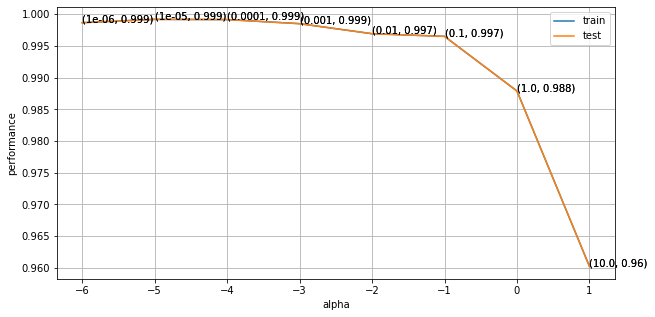

In [ ]:
# Plotting the result to select best parameter
result_visualization(lr_clf, param, param1='alpha')

In [ ]:
# Tuning "alpha" for l1 "penalty"
clf = SGDClassifier(loss='log', penalty='l1')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train_csr, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.018, test=-0.018), auc=(train=0.999, test=0.999), f1=(train=0.957, test=0.955), total=  24.9s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.7s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.015, test=-0.016), auc=(train=0.999, test=0.999), f1=(train=0.954, test=0.953), total=  30.8s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.022, test=-0.022), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.959), total=  26.5s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.034, test=-0.034), auc=(train=0.999, test=0.999), f1=(train=0.954, test=0.954), total=  25.8s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.046, test=-0.044), auc=(train=0.999, test=0.999), f1=(train=0.944, test=0.945), total=  25.7s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.022, test=-0.023), auc=(train=0.999, test=0.999), f1=(train=0.957, test=0.956), total=  14.7s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.021, test=-0.022), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.957), total=  14.5s
[CV] alpha=1e-05 .....................................................
[CV]  alph

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 11.2min finished


Best Score: 0.9991936630246743
Best Parameters: {'alpha': 1e-06}


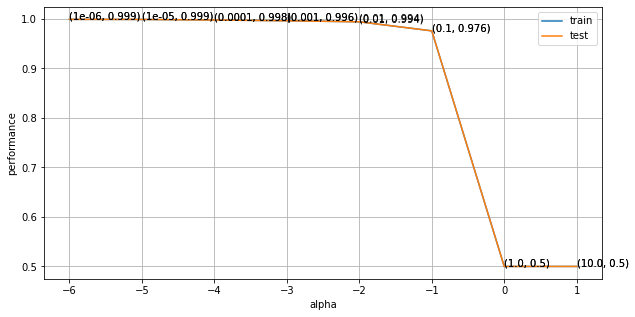

In [ ]:
# Plotting alpha vs score
result_visualization(lr_clf, param, 'alpha')

In [ ]:
# Best LR model
lr_bst_clf = SGDClassifier(penalty='l1', alpha=1e-6)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   LR  | 0.9878791093434393 | 0.9585322685085258 | 0.012120890656560756 |
|   Test  |   LR  | 0.9875316737082718 | 0.9581082448153768 | 0.012468326291728213 |
+---------+-------+--------------------+--------------------+----------------------+


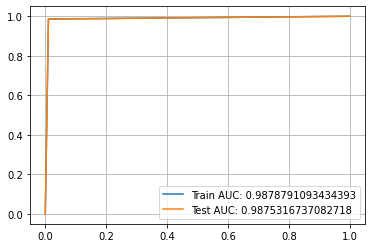

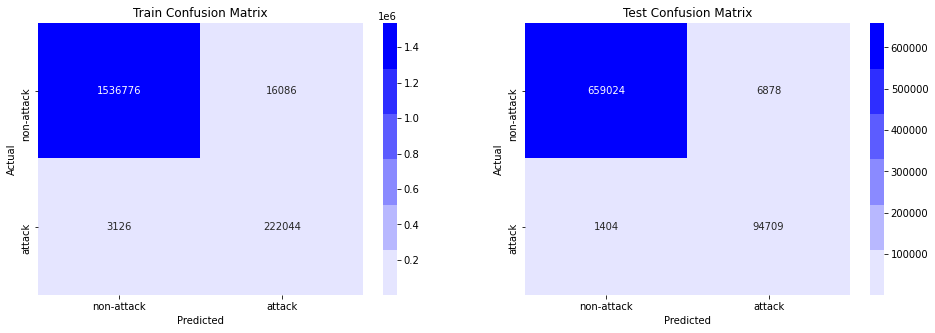

In [ ]:
# Getting best model's performance on train and test data
lr_clf, lr_auc, lr_f1, lr_far = evaluate_result(lr_bst_clf, x_train, y_train, x_test, y_test, 'LR')

**Observation**
1. Using wide range of values for "alpha" from 10^-6 to 10^3 and "penalty" l1 and l2
2. Can observe that upto alpha=0.1 model's score is good and then its falling down heavily.
3. The best parameter of the model for our data is "penalty" l1 and "alpha" 10^-6
4. Both train and test auc score are very close that means model is not overfitting.
5. Model is performing well but there are few False Positive points in the result

In [ ]:
# An empty dictionary to store the result of all the models
result_dict = {"name":[], "auc":[], "f1":[], "far":[]}

In [ ]:
# Storinig result for LR
result_dict['name'].append("LR")
result_dict['auc'].append(lr_auc)
result_dict['f1'].append(lr_f1)
result_dict['far'].append(lr_far)

In [ ]:
pickle.dump(lr_clf, open(file_path+'/lr_clf.pkl', 'wb'))

In [ ]:
result_dict

{'auc': [0.9875316737082718],
 'f1': [0.9581082448153768],
 'far': [0.012468326291728213],
 'name': ['LR']}

### Linear SVC
The next model we are going to try is Linear Support Vector Classifier

Tune parameters for "alpha" and "penalty"

In [ ]:
# Tuning "alpha" and "penalty"
clf = SGDClassifier(loss='hinge')
param = {'alpha':[10**x for x in range(-5,3)],  # Values for alpha
         'penalty':['l1', 'l2']}  # l1 an d l2 penalty

svm_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-05, penalty=l1 .........................................
[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.022, test=-0.023), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.957), total=  16.8s
[CV] alpha=1e-05, penalty=l1 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.030, test=-0.030), auc=(train=0.999, test=0.999), f1=(train=0.955, test=0.955), total=  20.1s
[CV] alpha=1e-05, penalty=l1 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.4s remaining:    0.0s


[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.038, test=-0.037), auc=(train=0.998, test=0.998), f1=(train=0.949, test=0.950), total=  11.5s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.015, test=-0.015), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.958), total=   9.5s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.027, test=-0.028), auc=(train=0.999, test=0.999), f1=(train=0.955, test=0.955), total=   9.5s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.009, test=-0.008), auc=(train=0.998, test=0.998), f1=(train=0.954, test=0.955), total=   8.6s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV]  alpha=0.0001, penalty=l1, FAR=(train=-0.021, test=-0.022), auc=(train=0.997, test=0.997), f1=(train=0.955, test=0.954), total=  19.5s
[CV] alpha=0.0001, p

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  8.4min finished


Best Score: 0.9990533249115621
Best Parameters: {'alpha': 0.0001, 'penalty': 'l2'}


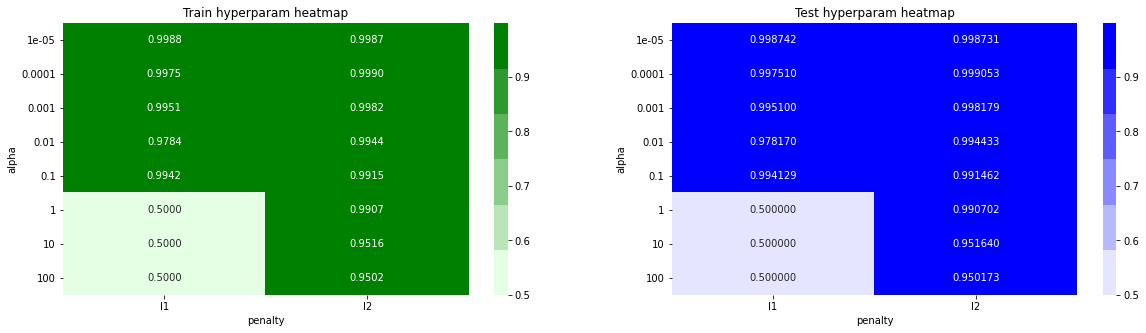

In [ ]:
# Visualising scores, using heatmap to check the performance on "alpha" and "penalty"
result_visualization(svm_clf, param, 'alpha', 'penalty')

In [ ]:
# Best svc model
best_svm_clf = svm_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |  SVM  | 0.9907030504693602 | 0.955294589640227  | 0.009296949530639703 |
|   Test  |  SVM  | 0.9906682443423142 | 0.9552035837133029 | 0.009331755657685866 |
+---------+-------+--------------------+--------------------+----------------------+


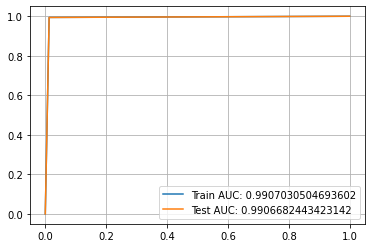

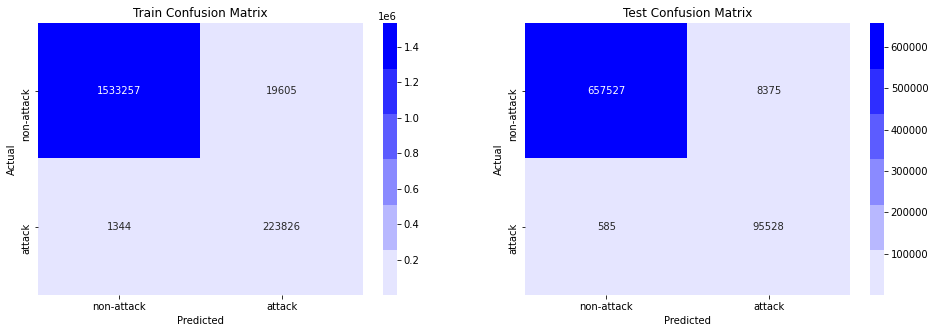

In [ ]:
# Model performance on train and test
svm_clf, svm_auc, svm_f1, svm_far = evaluate_result(clf, x_train_csr, y_train, x_test_csr, y_test, "SVM")

**Observation**
1. Using wide range of "alpha" values from 10^-5 to 10^2 and l1, l2 "penalty"
2. For penalty=l1 model is behaving like a random model with auc=0.5 from alpha=1 to 100.
3. Best set of parameters for the model is alpha=10^-4 and penalty=l2
4. Train and Test score is very close so no overfitting here, getting better value of auc and FAR tha Logistic Regression
5. FAR value of this model is really good. The no of FP increased than LR but there are very few FN points in the result.

In [ ]:
# Saving result of SVM
result_dict['name'].append("SVM")
result_dict['auc'].append(svm_auc)
result_dict['f1'].append(svm_f1)
result_dict['far'].append(svm_far)

In [ ]:
pickle.dump(svm_clf, open(file_path+'/svm_clf.pkl', 'wb'))

In [ ]:
pickle.dump(result_dict, open('result_dict.pkl', 'wb'))

### Decision Tree
Trying out DT for the next model.

Tune parameters for "max_depth", "min_samples_split" and "min_samples_leaf"

In [ ]:
# DT classifier
clf = DecisionTreeClassifier()
param = {'max_depth':[8, 10, 12, 14],
         'min_samples_split':[2, 4, 6]}

dt_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=8, min_samples_split=2 ................................
[CV]  max_depth=8, min_samples_split=2, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.959), total=  21.1s
[CV] max_depth=8, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV]  max_depth=8, min_samples_split=2, FAR=(train=-0.014, test=-0.015), auc=(train=0.999, test=0.999), f1=(train=0.962, test=0.962), total=  20.4s
[CV] max_depth=8, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.4s remaining:    0.0s


[CV]  max_depth=8, min_samples_split=2, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.959), total=  20.5s
[CV] max_depth=8, min_samples_split=4 ................................
[CV]  max_depth=8, min_samples_split=4, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.959), total=  19.2s
[CV] max_depth=8, min_samples_split=4 ................................
[CV]  max_depth=8, min_samples_split=4, FAR=(train=-0.014, test=-0.015), auc=(train=0.999, test=0.999), f1=(train=0.962, test=0.962), total=  19.1s
[CV] max_depth=8, min_samples_split=4 ................................
[CV]  max_depth=8, min_samples_split=4, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.959, test=0.959), total=  19.4s
[CV] max_depth=8, min_samples_split=6 ................................
[CV]  max_depth=8, min_samples_split=6, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.959, tes

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 14.7min finished


Best Score: 0.999392073501873
Best Parameters: {'max_depth': 10, 'min_samples_split': 6}


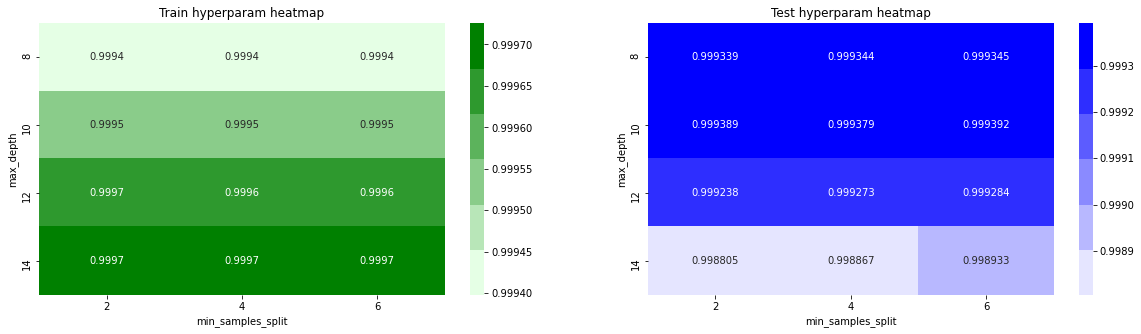

In [ ]:
# Plotting heatmap of scores with params
result_visualization(dt_clf, param, 'max_depth', 'min_samples_split')

In [ ]:
dt_clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Tuning "min_samples_leaf" on top of best found params
clf = dt_clf.best_estimator_
param = {'min_samples_leaf':[9, 11, 13]}

dt_clf = hyperparam_tuning(clf, param, x_train_csr, y_train,cv=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] min_samples_leaf=9 ..............................................
[CV]  min_samples_leaf=9, FAR=(train=-0.012, test=-0.012), auc=(train=1.000, test=0.999), f1=(train=0.964, test=0.963), total=  20.9s
[CV] min_samples_leaf=9 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s


[CV]  min_samples_leaf=9, FAR=(train=-0.029, test=-0.031), auc=(train=1.000, test=0.999), f1=(train=0.963, test=0.961), total=  21.2s
[CV] min_samples_leaf=9 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.9s remaining:    0.0s


[CV]  min_samples_leaf=9, FAR=(train=-0.013, test=-0.013), auc=(train=1.000, test=0.999), f1=(train=0.964, test=0.963), total=  20.8s
[CV] min_samples_leaf=11 .............................................
[CV]  min_samples_leaf=11, FAR=(train=-0.012, test=-0.012), auc=(train=1.000, test=0.999), f1=(train=0.963, test=0.963), total=  21.2s
[CV] min_samples_leaf=11 .............................................
[CV]  min_samples_leaf=11, FAR=(train=-0.029, test=-0.031), auc=(train=1.000, test=0.999), f1=(train=0.963, test=0.961), total=  21.7s
[CV] min_samples_leaf=11 .............................................
[CV]  min_samples_leaf=11, FAR=(train=-0.013, test=-0.013), auc=(train=1.000, test=0.999), f1=(train=0.964, test=0.963), total=  21.0s
[CV] min_samples_leaf=13 .............................................
[CV]  min_samples_leaf=13, FAR=(train=-0.012, test=-0.012), auc=(train=1.000, test=0.999), f1=(train=0.963, test=0.963), total=  21.1s
[CV] min_samples_leaf=13 .................

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.5min finished


Best Score: 0.9994570950856413
Best Parameters: {'min_samples_leaf': 9}


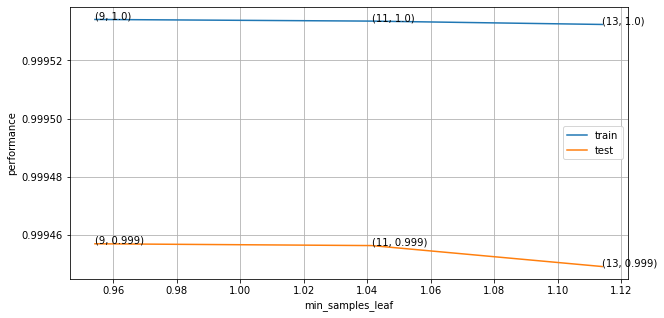

In [ ]:
result_visualization(dt_clf, param, 'min_samples_leaf')

Best value of "min_samples_leaf" is 11

In [ ]:
dt_param = {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf':9}

dt_best_clf = DecisionTreeClassifier(**dt_param)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   DT  | 0.9879649532321753 | 0.9634806494164075 | 0.012035046767824754 |
|   Test  |   DT  | 0.9877445111630792 | 0.9628513698525557 | 0.012255488836920861 |
+---------+-------+--------------------+--------------------+----------------------+


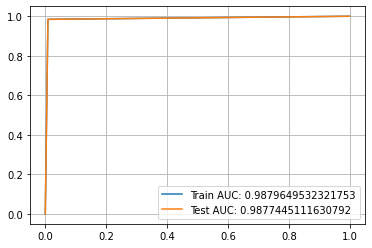

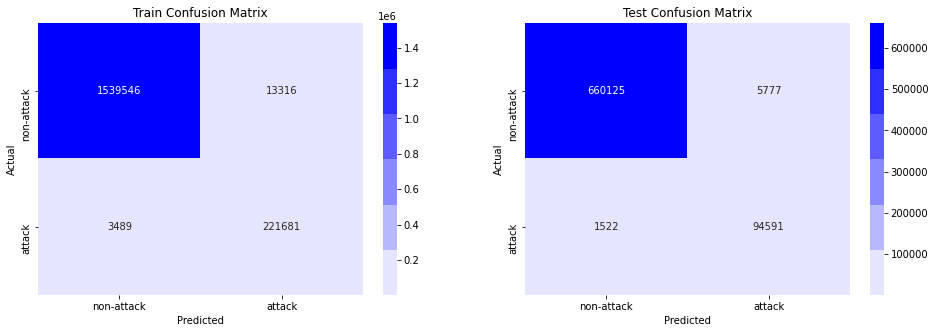

In [ ]:
dt_clf, dt_auc, dt_f1, dt_far = evaluate_result(dt_best_clf, x_train_csr, y_train, x_test_csr, y_test, 'DT')

In [ ]:
# Saving the Model to disk
pickle.dump(dt_clf, open(file_path+'/dt_clf.pkl', 'wb'))

In [ ]:
result_dict = pickle.load(open('./result_dict.pkl', 'rb'))

In [ ]:
# Saving scores of DT
result_dict['name'].append("DT")
result_dict['auc'].append(dt_auc)
result_dict['f1'].append(dt_f1)
result_dict['far'].append(dt_far)

In [ ]:
result_dict

{'auc': [0.9875316737082718, 0.9906682443423142, 0.9877445111630792],
 'f1': [0.9581082448153768, 0.9552035837133029, 0.9628513698525557],
 'far': [0.012468326291728213, 0.009331755657685866, 0.012255488836920861],
 'name': ['LR', 'SVM', 'DT']}

**Observation**
1. Tuning parameters for "max_depth", "min_sampples_split" and "min_samples_leaf".
2. Performance is mostly dependent on "max_depth" and less dependent on other 2 params.
3. Best parameters for the model max_depth=10, min_samples_split=6 and min_samples_leaf=9
4. Train and Test score is very close so no overfitting here, getting better value of F1 score with this model than the other 2 abve.
5. NO of False Positive reduced for this model.

<br>

## Cross Validation function

For Random Forest and XGBClassifier, we will tuning its hyperparameters with train and cv data and using loops. Because the dataset is very large and with grid or randomsearch it will take so much time.

In [ ]:
# Splitting train in train and cv data
x_train_new_csr, x_cv_csr, y_train, y_cv = train_test_split(x_train_csr, y_train, test_size=0.2, random_state=42)

In [ ]:
x_train_new_csr.shape, y_train.shape, x_cv_csr.shape, y_cv.shape, x_test_csr.shape, y_test.shape

((1422425, 197),
 (1422425,),
 (355607, 197),
 (355607,),
 (762015, 197),
 (762015,))

In [ ]:
def cross_validation(clf_name, param, param_tune,
                     x_train=x_train_new_csr, y_train=y_train, x_cv=x_cv_csr, y_cv=y_cv):
    """
    Using this function to cross validate with train and cv data.
    Parameters:
        clf_name = Name of the classifier
        param = Dictionary of hyperparameters and params for classifier
        param_tune = Name of the parameter to tune
        x_train, y_train = Train data and Train label
        x_cv, y_cv = CV data and CV label
    """
    # Initializing empty list to store train and cv scores
    train_auc_list = []
    cv_auc_list = []
    
    # Assigning arguments to variables
    hyper_param = param_tune
    values = param.pop(hyper_param)
    classifier = clf_name

    # Looping through the list of hyper parameter
    for i in tqdm(values):
        clf = classifier(**{hyper_param:i}, **param, n_jobs=-1)
        clf.fit(x_train, y_train)  # Training

        # Predicting probability of targets
        y_train_pred = clf.predict_proba(x_train)[:,1]
        y_cv_pred = clf.predict_proba(x_cv)[:,1]

        # Getting scores
        train_auc_list.append(roc_auc_score(y_train, y_train_pred))
        cv_auc_list.append(roc_auc_score(y_cv, y_cv_pred))

        print("For {}: {}, train auc: {} and test auc {}".format(hyper_param, i, train_auc_list[-1], cv_auc_list[-1]))
    
    # Plotting scores
    plt.figure(figsize=(10,5))
    plt.plot(values, train_auc_list, label="train")
    plt.plot(values, cv_auc_list, label="cv")

    for i, txt in enumerate(train_auc_list):
        plt.annotate((values[i], np.round(txt, 3)), (values[i], train_auc_list[i]))
    for i, txt in enumerate(cv_auc_list):
        plt.annotate((values[i], np.round(txt, 3)), (values[i], cv_auc_list[i]))
    
    plt.xlabel(hyper_param)
    plt.ylabel('auc score')
    plt.grid()
    plt.legend()
    plt.show()

    # Finding best parameter with highest cv score
    best_param = np.argmax(cv_auc_list)
    clf = classifier(**{hyper_param:values[best_param]}, **param)  # Trained model

    return clf, hyper_param, values[best_param]

### Random Forest

Trying Random Forest Classifier next.
<br>
Tuning 'n_estimators', 'max_depth', 'min_samples_split' and 'criterion'

In [ ]:
# Classifier Name
CLF_NAME = RandomForestClassifier

 25%|██▌       | 1/4 [05:25<16:15, 325.29s/it]

For n_estimators: 100, train auc: 0.9999999495503196 and test auc 0.9997536231465426


 50%|█████     | 2/4 [16:12<14:03, 421.94s/it]

For n_estimators: 200, train auc: 0.999999938517524 and test auc 0.9997695006545962


 75%|███████▌  | 3/4 [32:31<09:48, 588.91s/it]

For n_estimators: 300, train auc: 0.9999999421549058 and test auc 0.9997929597061752


100%|██████████| 4/4 [52:04<00:00, 781.05s/it]

For n_estimators: 400, train auc: 0.9999999442148972 and test auc 0.9997720797852118


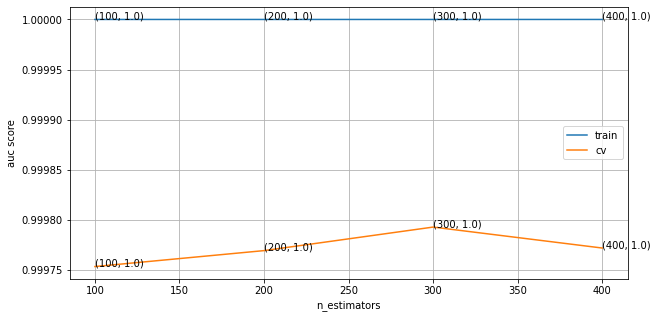

In [ ]:
# Tuning No of estimators
param = {'n_estimators':[100, 200, 300, 400]}
rf_clf, param1, val1 = cross_validation(CLF_NAME, param, 'n_estimators')

 33%|███▎      | 1/3 [08:18<16:37, 498.56s/it]

For max_depth: 20, train auc: 0.9999325025771456 and test auc 0.9997716908258433


 67%|██████▋   | 2/3 [17:43<08:38, 518.43s/it]

For max_depth: 22, train auc: 0.9999644626999398 and test auc 0.9997806253072725


100%|██████████| 3/3 [28:28<00:00, 569.48s/it]

For max_depth: 24, train auc: 0.9999857388740565 and test auc 0.9997762854731862


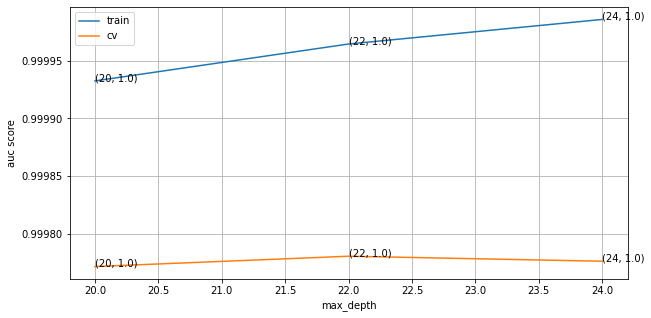

In [ ]:
# Tuning Max depth
param = {'max_depth':[20, 22, 24]}
dt_clf, param2, val2 = cross_validation(CLF_NAME, param, 'max_depth')

 33%|███▎      | 1/3 [03:35<07:10, 215.41s/it]

For min_samples_split: 2, train auc: 0.9999642016574748 and test auc 0.9997674902148269


 67%|██████▋   | 2/3 [07:16<03:37, 217.07s/it]

For min_samples_split: 4, train auc: 0.9999520574340831 and test auc 0.999775468154392


100%|██████████| 3/3 [10:43<00:00, 214.41s/it]

For min_samples_split: 6, train auc: 0.9999400201760789 and test auc 0.9997755399468738


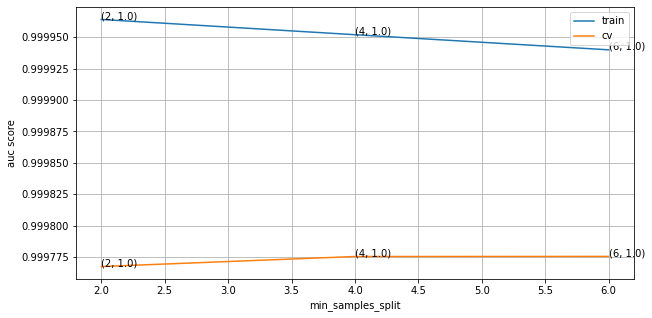

In [ ]:
# Tuning Min samples split
param = {'min_samples_split':[2, 4, 6], 'max_depth':22}
dt_clf = cross_validation(CLF_NAME, param, 'min_samples_split')

 50%|█████     | 1/2 [03:39<03:39, 219.52s/it]

For criterion: gini, train auc: 0.999941892813254 and test auc 0.9997759872555106


100%|██████████| 2/2 [06:49<00:00, 204.79s/it]

For criterion: entropy, train auc: 0.999923816545292 and test auc 0.9997642074606826


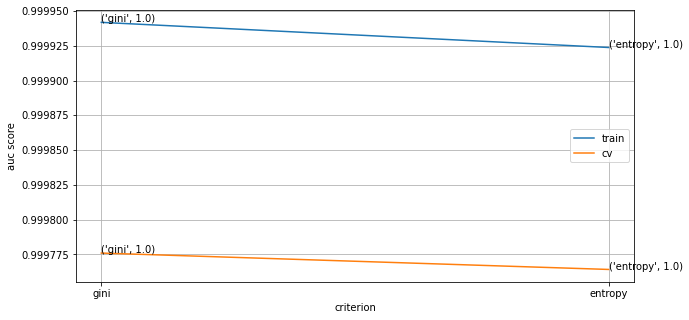

In [ ]:
# Tuning Criterion
param = {'criterion':['gini', 'entropy'], 'min_samples_split':6, 'max_depth':22}
dt_clf, _, _ = cross_validation(CLF_NAME, param, 'criterion')

In [ ]:
# Best RandomForest model
rf_bst_clf = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   RF  | 0.9927925575846711 | 0.9897532424861752 | 0.007207442415328972 |
|   Test  |   RF  | 0.9854768258366028 | 0.9767504956694146 | 0.01452317416339732  |
+---------+-------+--------------------+--------------------+----------------------+


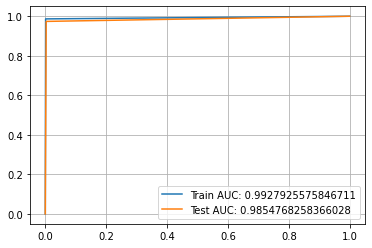

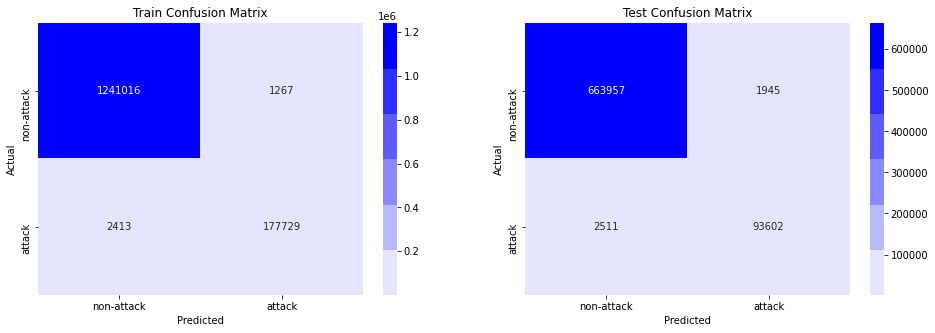

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=22, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=6,
                        min_weight_fraction_leaf=0.0, n_estimators=300,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 0.9854768258366028,
 0.9767504956694146,
 0.01452317416339732)

In [ ]:
# Getting result on train and test data
evaluate_result(rf_bst_clf, x_train_new_csr, y_train, x_test_csr, y_test, "RF")

**Observation**
1. Tuning lots of parameters for this classifier with appropriate values.
2. Performance is mostly dependent on "n_estimators", "max_depth" and less dependent on other 2 params.
3. Best parameters for the model: criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300
4. Train and Test score is  close but compared to above models there is a gap between train and test score. So it is overfitting on train data if wwe compare with above models. But the gap is very low so not much of overfitting.
5. No of False Positive reduced heavily, but No of False Negetive incresed.

In [ ]:
pickle.dump(rf_bst_clf, open(file_path+'/rf_best_clf.pkl', 'wb'))

In [ ]:
result_dict = pickle.load(open('result_dict.pkl', 'rb'))

In [ ]:
# Adding results
result_dict['name'].append("RF")
result_dict['auc'].append(0.9854768258366028)
result_dict['f1'].append(0.9767504956694146)
result_dict['far'].append(0.01452317416339732)

In [ ]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.987532,0.958108,0.012468
1,SVM,0.990668,0.955204,0.009332
2,DT,0.987745,0.962851,0.012255
3,RF,0.985477,0.976750,0.014523


In [ ]:
pickle.dump(result_dict, open(file_path+'/final_result_dict.pkl', 'wb'))

### GBDT

Trying out Gradient boosted decision tree.

For this model there are lots of hyperparameters to tune like, 'learning_rate', 'max_depth', 'colsample_bylevel', 'subsample' and 'n_estimators'

In [ ]:
CLF_NAME = xgb.XGBClassifier

 33%|███▎      | 1/3 [11:04<22:08, 664.10s/it]

For learning_rate: 0.001, train auc: 0.9988952012572503 and test auc 0.9989022198344989


 67%|██████▋   | 2/3 [21:56<11:00, 660.55s/it]

For learning_rate: 0.01, train auc: 0.9992489559290703 and test auc 0.9992516463938936


100%|██████████| 3/3 [33:01<00:00, 660.65s/it]

For learning_rate: 0.1, train auc: 0.999593216098385 and test auc 0.9995963520970502


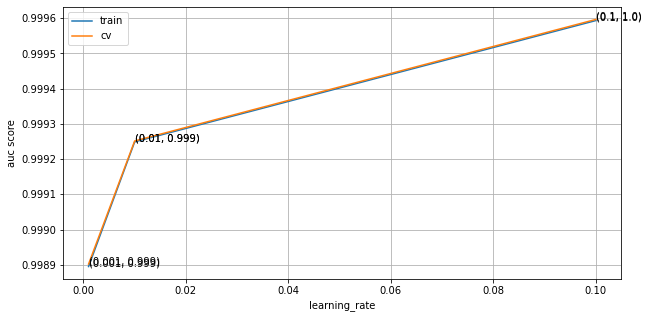

In [ ]:
param = {'learning_rate':[0.001, 0.01, 0.1]}
xgb_clf = cross_validation(CLF_NAME, param, 'learning_rate')

 33%|███▎      | 1/3 [15:18<30:37, 918.96s/it]

For max_depth: 4, train auc: 0.9996625653998681 and test auc 0.9996580253071718


 67%|██████▋   | 2/3 [41:44<18:39, 1119.01s/it]

For max_depth: 8, train auc: 0.999814126656039 and test auc 0.9997761363107185


100%|██████████| 3/3 [1:19:45<00:00, 1595.00s/it]

For max_depth: 12, train auc: 0.9999196276935792 and test auc 0.9998429652793456


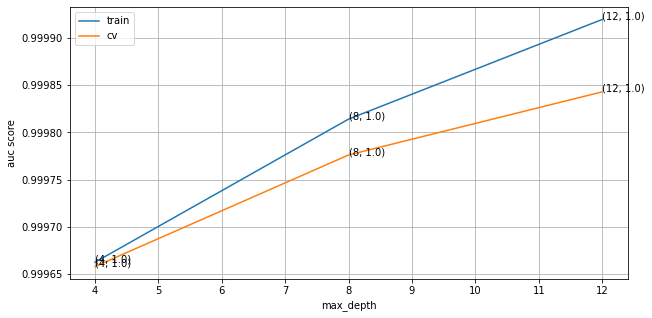

In [ ]:
param = {'max_depth':[4, 8, 12]}

xgb_clf, _, _ = cross_validation(CLF_NAME, param, 'max_depth')


In [ ]:
train_sample = np.random.randint(0, x_train.shape[0], size=700000)

 33%|███▎      | 1/3 [01:32<03:05, 92.74s/it]

For colsample_bylevel: 0.1, train auc: 0.9995604258174032 and test auc 0.9995394868380301


 67%|██████▋   | 2/3 [04:46<02:02, 122.90s/it]

For colsample_bylevel: 0.5, train auc: 0.9996159891897697 and test auc 0.9996041733659695


100%|██████████| 3/3 [10:06<00:00, 202.23s/it]

For colsample_bylevel: 1, train auc: 0.9996075349353707 and test auc 0.9995991161433612


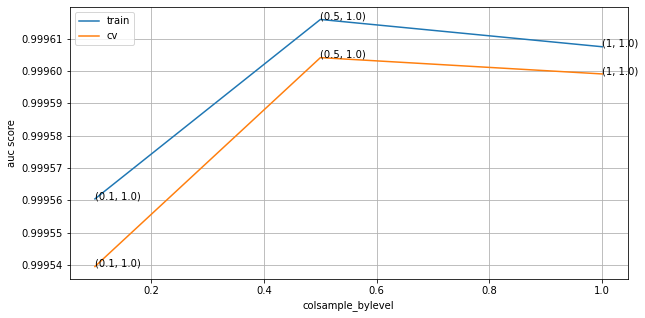

In [ ]:
param = {'colsample_bylevel':[0.1, 0.5, 1]}
xgb_clf,_,_ = cross_validation(CLF_NAME, param, 'colsample_bylevel', x_train=x_train.iloc[train_sample], y_train=y_train.iloc[train_sample])

 25%|██▌       | 1/4 [04:07<12:23, 247.77s/it]

For subsample: 0.1, train auc: 0.9996238655949573 and test auc 0.999613669923898


 50%|█████     | 2/4 [10:17<09:28, 284.21s/it]

For subsample: 0.4, train auc: 0.9996229084609838 and test auc 0.9996115178298388


 75%|███████▌  | 3/4 [16:35<05:12, 312.46s/it]

For subsample: 0.7, train auc: 0.9996185730003202 and test auc 0.9996096150430395


100%|██████████| 4/4 [21:48<00:00, 327.18s/it]

For subsample: 1, train auc: 0.9996075349353707 and test auc 0.9995991161433612


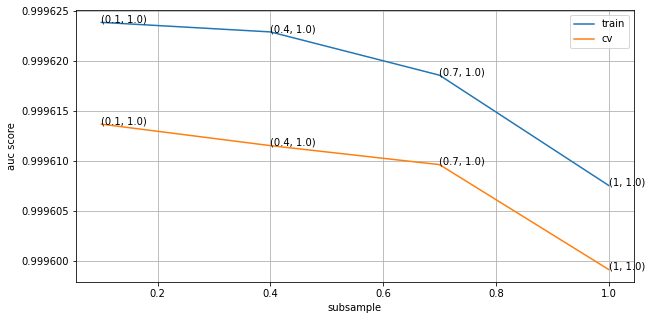

In [ ]:
param = {'subsample':[0.1, 0.4, 0.7, 1]}
xgb_xlf,_,_ = cross_validation(CLF_NAME, param, 'subsample', x_train=x_train.iloc[train_sample], y_train=y_train.iloc[train_sample])

 33%|███▎      | 1/3 [10:34<21:08, 634.02s/it]

For n_estimators: 200, train auc: 0.9996954660106072 and test auc 0.9996688047624311


 67%|██████▋   | 2/3 [26:20<12:07, 727.79s/it]

For n_estimators: 300, train auc: 0.9997390417498165 and test auc 0.9996977639118547


100%|██████████| 3/3 [47:09<00:00, 943.19s/it]

For n_estimators: 400, train auc: 0.9997804231677948 and test auc 0.9997233525687121


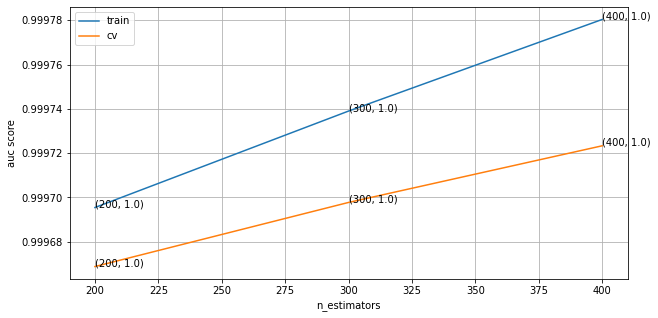

In [ ]:
param = {'n_estimators':[200, 300, 400]}
xgb_clf,_,_ = cross_validation(CLF_NAME, param, 'n_estimators', x_train=x_train.iloc[train_sample], y_train=y_train.iloc[train_sample])

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |  XGB  | 0.9953893531099667 | 0.9920798181106495 | 0.004610646890033333 |
|   Test  |  XGB  | 0.9864086030089578 | 0.9763625484533937 | 0.013591396991042138 |
+---------+-------+--------------------+--------------------+----------------------+


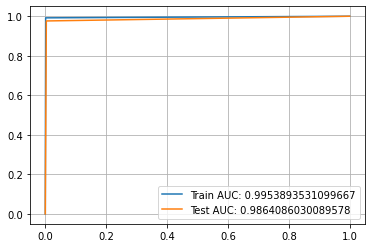

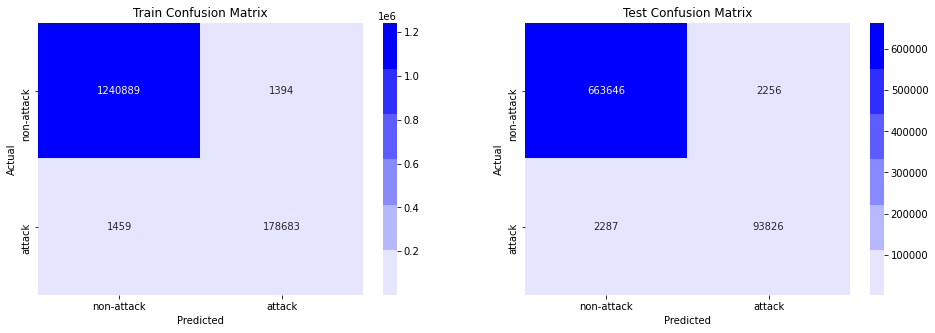

In [ ]:
best_params = {'n_estimators':400,
               'max_depth':12,
               'learning_rate':0.1,
               'colsample_bylevel':0.5,
               'subsample':0.1,
               'n_jobs':-1}

xgb_bst_clf = xgb.XGBClassifier(**best_params)
xgb_clf, xgb_auc, xgb_f1, xgb_far = evaluate_result(xgb_bst_clf, x_train_new_csr, y_train, x_test_csr, y_test, 'XGB')

In [ ]:
pickle.dump(xgb_clf, open(file_path+'/xgb_clf.pkl', 'wb'))

In [ ]:
result_dict = pickle.load(open(file_path+'/final_result_dict.pkl', 'rb'))

In [ ]:
result_dict['name'].append('XGB')
result_dict['auc'].append(xgb_auc)
result_dict['f1'].append(xgb_f1)
result_dict['far'].append(xgb_far)

In [ ]:
pd.DataFrame(result_dict)[['name', 'auc', 'f1', 'far']]

,name,auc,f1,far
0,LR,0.987532,0.958108,0.012468
1,SVM,0.990668,0.955204,0.009332
2,DT,0.987745,0.962851,0.012255
3,RF,0.985477,0.976750,0.014523
4,XGB,0.986409,0.976363,0.013591


**Observation**
1. Tuning lots of parameters for this classifier with appropriate values.
2. Performance is mostly dependent on "learning_rate" somewhat on "max_depth" and "n_estimators" and less dependent on other 2 params.
3. Best parameters for the model- 'n_estimators':400, 'max_depth':12, 'learning_rate':0.1,              'colsample_bylevel':0.5, 'subsample':0.1,              'n_jobs':-1
4. Train and Test score is  close but compared to above models there is a gap between train and test score. So it is overfitting on train data if wwe compare with above models. But the gap is very low so not much of overfitting.
5. In train data FAR is very very low, but in test there is still almost equal FN and FP

In [ ]:
pickle.dump(result_dict, open('result_dict.pkl', 'wb'))

In [ ]:
XGB_clf = pickle.load(open(file_path+'/xgb_clf.pkl', 'rb'))

### Getting Important features

In [ ]:
# Totol features with some importance
np.count_nonzero(XGB_clf.feature_importances_)

55

In [ ]:
# Getting the indices of the features sorted in descending order
indices = np.argsort(-1 * abs(xgb_clf.feature_importances_))[:55]

In [ ]:
# Saving for later use
saved_dict['imp_indices'] = indices

In [ ]:
pickle.dump(saved_dict, open(file_path+'/saved_dict.pkl', 'wb'))

In [ ]:
x_train_new_csr[:,indices].shape

(1422425, 55)

### Plotting Features and their Importance

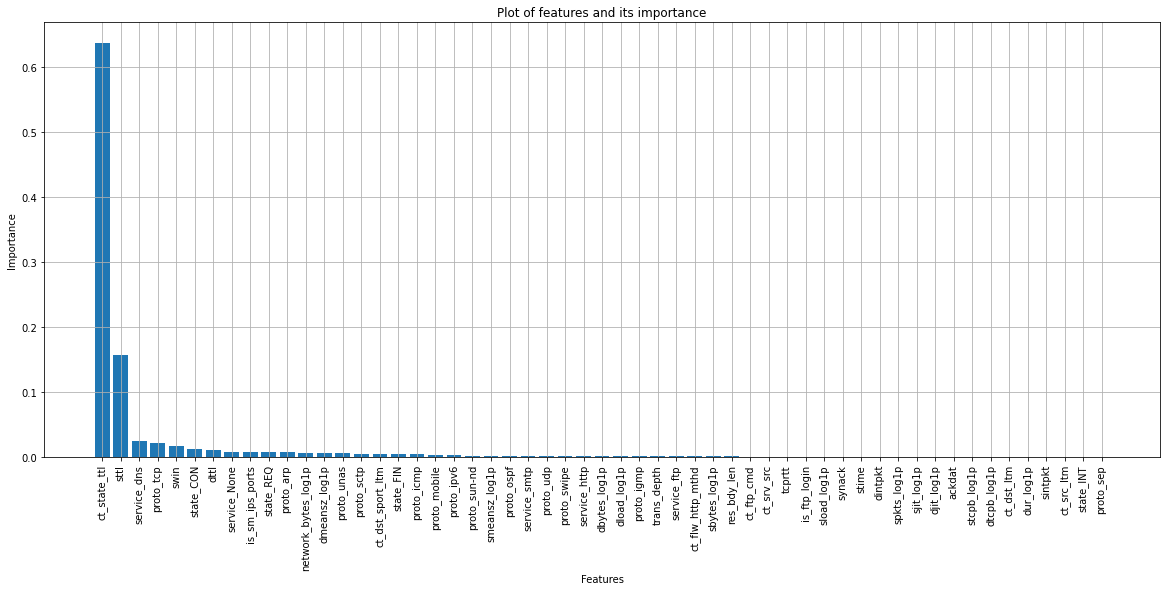

In [ ]:
plt.figure(figsize=(20,8))
plt.bar(x_train.columns[indices], abs(xgb_clf.feature_importances_[indices]))
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot of features and its importance")
plt.grid()
plt.show()

## Models on Important features

Again Training few models from above and then compare the result of model with all parameters and only important parameters.

### DT with Imp Param

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  | DT_FI | 0.9877171512513443 | 0.9632672801919372 | 0.012282848748655734 |
|   Test  | DT_FI | 0.9873268326487022 | 0.9624191076511052 | 0.01267316735129774  |
+---------+-------+--------------------+--------------------+----------------------+


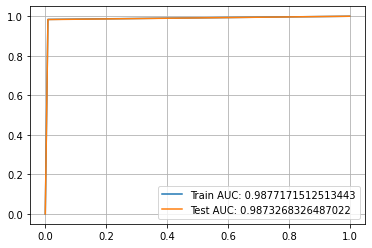

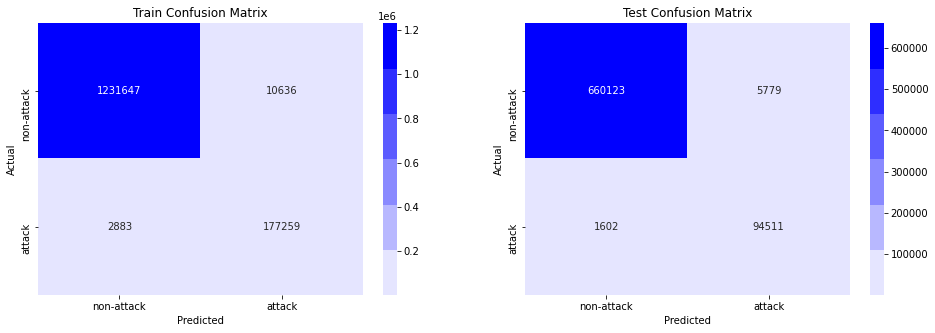

In [ ]:
dt_clf_imp = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
dt_clf_imp, dt_fi_auc, dt_fi_f1, dt_fi_far = evaluate_result(dt_clf_imp, x_train_new_csr[:,indices], y_train, x_test_csr[:,indices], y_test, 'DT_FI')

In [ ]:
#result_dict = pickle.load(open('result_dict.pkl', 'rb'))

result_dict['name'].append('DT_FI')
result_dict['auc'].append(dt_fi_auc)
result_dict['f1'].append(dt_fi_f1)
result_dict['far'].append(dt_fi_far)

In [ ]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.987532,0.958108,0.012468
1,SVM,0.990668,0.955204,0.009332
2,DT,0.987745,0.962851,0.012255
3,RF,0.985477,0.976750,0.014523
4,XGB,0.986409,0.976363,0.013591
5,DT_FI,0.987327,0.962419,0.012673


**Observations**
1. Retraining the best Decision Tree model with data containing only important features.
2. From observing the result we can see that there is not much difference in scores, but yes they have reduced very little.

In [ ]:
pickle.dump(dt_clf_imp, open(file_path+'/dt_clf_imp.pkl', 'wb'))

### RF with Imp Params

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  | RF_FI | 0.993994564273112  | 0.9919767406239818 | 0.006005435726888063 |
|   Test  | RF_FI | 0.9862268589810488 | 0.978034935409145  | 0.013773141018951229 |
+---------+-------+--------------------+--------------------+----------------------+


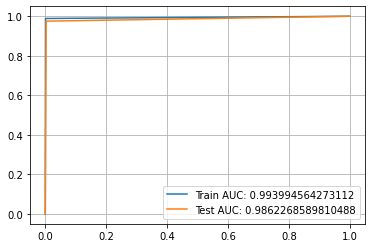

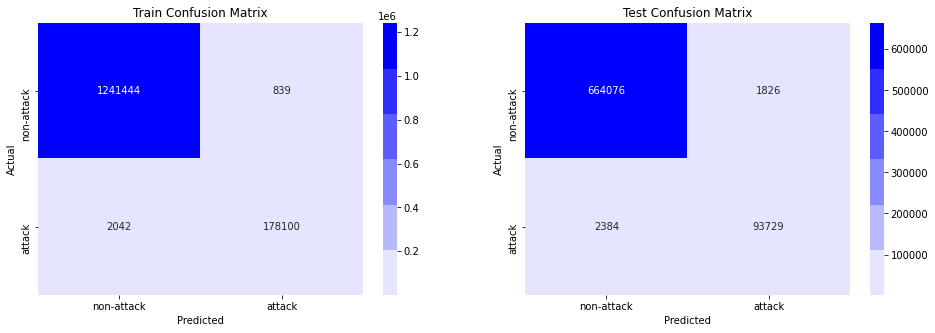

In [ ]:
rf_clf_imp = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)
rf_clf_imp, rf_fi_auc, rf_fi_f1, rf_fi_far = evaluate_result(rf_clf_imp, x_train_new_csr[:,indices], y_train, x_test_csr[:,indices], y_test, 'RF_FI')

In [ ]:
pickle.dump(rf_clf_imp, open(file_path+'/rf_clf_imp.pkl', 'wb'))

In [ ]:
for i,j in zip(result_dict.keys(), ["RF_FI", rf_fi_auc, rf_fi_f1, rf_fi_far]):
    result_dict[i].append(j)

In [ ]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.987532,0.958108,0.012468
1,SVM,0.990668,0.955204,0.009332
2,DT,0.987745,0.962851,0.012255
3,RF,0.985477,0.976750,0.014523
4,XGB,0.986409,0.976363,0.013591
5,DT_FI,0.987327,0.962419,0.012673
6,RF_FI,0.986227,0.978035,0.013773


**Observations**
1. Training the best Random Forest model again with only important features
2. We can see that the performance has increased
3. This model is giving the highest scores amongst all the models we have trained till now

In [ ]:
# Re-creating data with imp feat

x_train = x_train_new_csr[:, indices]
x_cv = x_cv_csr[:, indices]
x_test = x_test_csr[:, indices]

In [ ]:
x_train.shape, x_cv.shape, x_test.shape

((1422425, 55), (355607, 55), (762015, 55))

## Ensembles

### Voting Classifier Model

Trining a ensemble model using voting classifier, Taking 3 classifiers DecisionTree, RandomForest and XGBClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
# Initializing all the 3 classifiers with best found parameters
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
rf_clf = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.1, colsample_bylevel=0.5, subsample=0.1, n_jobs=-1)

+---------+------------+--------------------+--------------------+----------------------+
| Dataset |   Model    |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+------------+--------------------+--------------------+----------------------+
|  Train  | Voting Clf | 0.9948370110686883 | 0.991522693183712  | 0.00516298893131188  |
|   Test  | Voting Clf | 0.9869855717432889 | 0.9779374625738759 | 0.013014428256710994 |
+---------+------------+--------------------+--------------------+----------------------+


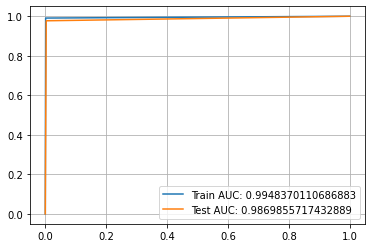

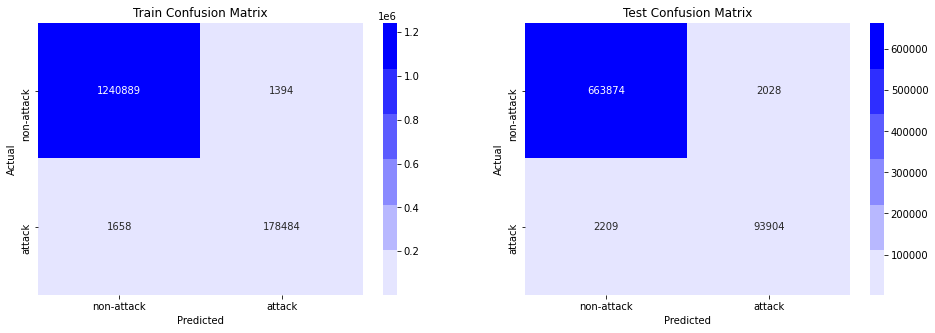

In [ ]:
# Result with voting classifier
v_clf = VotingClassifier(estimators=[('dt', dt_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)
v_clf, v_auc, v_f1, v_far = evaluate_result(v_clf, x_train, y_train, x_test, y_test, "Voting Clf")

In [ ]:
pickle.dump(v_clf, open(file_path+'/v_clf.pkl', 'wb'))

In [ ]:
for i,j in zip(result_dict.keys(), ["Voting", v_auc, v_f1, v_far]):
    result_dict[i].append(j)

In [ ]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.987532,0.958108,0.012468
1,SVM,0.990668,0.955204,0.009332
2,DT,0.987745,0.962851,0.012255
3,RF,0.985477,0.976750,0.014523
4,XGB,0.986409,0.976363,0.013591
5,DT_FI,0.987327,0.962419,0.012673
6,RF_FI,0.986227,0.978035,0.013773
7,Voting,0.986986,0.977937,0.013014


**Observations**
1. Training this model using 3 model best Dt, best RF and best XGB.
2. The auc score of this model is higher than any other model.
3. There is a gap in train and test auc and higher gap in train and test f1 and FAR
4. In train the FAR is very very low but in test there are still few FP and FN and they are almost equal in number

In [ ]:
pickle.dump(result_dict, open(file_path+'/final_result_dict.pkl', 'wb'))

In [ ]:
best_model = pickle.load(open(file_path+'/rf_clf_imp.pkl', 'rb'))

In [ ]:
f1_score(y_test, best_model.predict(x_test_csr[:, indices]))

0.978034935409145